# Carbon Assessment of Business Travels (Data Conditioning)

In [1]:
import sys
import time
import pathlib
import pandas as pd
import geopandas as gpd
import geocoder
from geopy.distance import geodesic
#from fuzzymatcher import link_table, fuzzy_left_join
%matplotlib inline
pd.set_option('display.max_rows', 300)

## Forewords

### Disclaimer

 > Data insights provided in this notebook are not validated and may certainly contain errors. They are shared for feedback only with no warranty or liability of any kind.

### Credits

Please refer (citation) to this preliminary report as follow:

 > Report [not validated]: *Carbon Assessment of Business Travels (Data Conditioning)*, Jean Landercy (SmartCampus), 2020-03-20

Additionally, also cite sources listed below.

### History

 - 2020-03-18: Started to explore Missions Dataset provided by ULB/DTAS/BEP;
 - 2020-03-20: First version of this report submitted to review;

### Sources

 - ULB/Faculty, Faculty mission: anonymized administrative forms (CSV);
 - ULB/DTAS/BEP, Travel Types Carbon Coefficient (Excel);
 - ArgGIS Hub, Country of the World (GeoJSON);
 - OSM, Nominatim Geocoding API (JSON);
 
### Methodology

 - Add index to mission records;
 - Permute reversed timestamps;
 - First cleansing of city names;
 - Split multiple destinations (origin is assumed to be unique): mission becomes travel;
 - Expand destinations;
 - Second cleansing of all city names;
 - Fill missing origin using Brussels as default;
 - Correct about 100 misspelled cities;
 - Geocode cleansed city names;
 - Add index to travel records;
 - Building geometries with Coordinate Reference System EPSG:4326;
 - Computing Geodesic Distance in km between geometries using WGS-84 ellipsoid as reference;


## Load dataset

Load raw data provided by ULB/BEP as ODT spreadsheet (converted to CSV to be compliant with Pandas). Adding missing mission index.

In [2]:
missions = pd.read_csv("data/missions.csv", sep=';', header=0, encoding='cp1250', parse_dates=['debut', 'fin'])
missions = missions.reset_index().rename(columns={'index': 'mission_id'})
missions = missions.drop('libelle', axis=1)
missions.sample(5)

,mission_id,debut,fin,pays_origine,ville_origine,pays,ville,lieu,mode_deplacement,acronyme,faculte
4847,4847,2019-01-18,2019-01-25,Belgique,Bruxelles,France,Caen,Université de Caen Basse Normandie [FR],voiture_diesel,HAA,PHILOSCSOC
265,265,2011-03-24,2011-03-27,NaN,NaN,France,Paris,FIDH et Hôtel de Ville de Paris,NaN,DECA,LTC
2627,2627,2016-11-17,2016-11-19,NaN,NaN,Russie,Moscou,"Lomonosov Moscow State University, Faculty of ...",NaN,DECA,LTC
4137,4137,2018-06-07,2018-06-09,Belgique,Bruxelles,France,Paris,U. Londres,train,L&L,LTC
1122,1122,2013-11-06,2013-11-09,NaN,NaN,espagne,barcelone,6-8 November 2013Universitat Autňnoma de Barce...,NaN,SIC,LTC


## Data Cleansing

### Swap inverted timestamps

There are inverted timestamps in dataset. Find and swap them, then compute elapsed time in number of days.

In [3]:
missions['elapsed'] = (missions['fin'] - missions['debut']).dt.days
missions.loc[missions['elapsed']<0,'fin'] = missions.loc[missions['elapsed']<0,'debut'].values
missions.loc[missions['elapsed']<0,'debut'] = missions.loc[missions['elapsed']<0,'fin'].values
missions['elapsed'] = ((missions['fin'] - missions['debut']) + pd.Timedelta("1D")).dt.days

### Correct subpopulated category

There are a modality `PHILA` in `acronyme` that contains only 3 observations. We suspect it is a typo for `PHILO`.

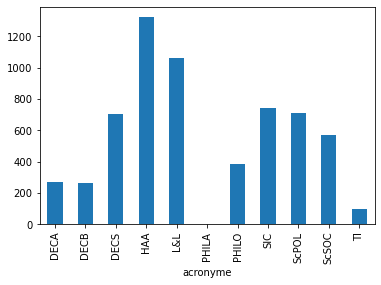

In [4]:
missions.groupby('acronyme')["mission_id"].count().plot(kind='bar')

In [5]:
missions['acronyme'] = missions['acronyme'].replace({'PHILA': 'PHILO'}) 

### Normalize city names

Columns `city` and `country` (origin and destination) are unconstrained text fields. Those data are ill-defined and contain a lot of errors. A cleansing is required before doing any statistics. We focus only on city as if we are able to get it right country will be deduced from it.

First step we normalize country names.

In [6]:
def norm(x, fromkey, tokey):
    x[tokey] = x[fromkey].str.normalize('NFKD')\
                         .str.encode('ascii', errors='ignore').str.decode('utf-8')\
                         .str.strip().str.lower()

In [7]:
norm(missions, 'ville_origine', 'from_city')
norm(missions, 'ville', 'dest_city')

### Cleanse & split normalized city names

Destination column may contain multiple destinations with several kind of separators. We split destination using Regular Expression. This operation is not absolute since dash (`-`) has a meaning in city names but is somethime used as a separator. This step might introduces an error (we assume it below 0.1%)

In [8]:
regreplace = r"\((.*?)\)"
regsplit = r'/|,|\&| et | puis |\+| and | - |;'
missions['dest_city'] = missions['dest_city'].str.replace(regreplace,"").str.split(regsplit)

Then we unnest destinations to get as many as there is (`origin`,`destination`) combination. This step transforms the concept of **mission** into a subconcept of **travel**. City names are then stripped.

In [9]:
df = missions.explode('dest_city')
df['dest_city'] = df['dest_city'].str.replace("\d", "")
df['dest_city'] = df['dest_city'].str.strip()

There is about 2% (about 100 records) of city names that are too erroneous to be corrected as this. We dump them and correct manually to recover from errors.

Load manually corrected city names and apply correction to dataset:

In [10]:
citytrans = pd.read_csv("data/city_trans.csv")
citytrans.tail()

,city,corrected
86,abidjen,abidjan
87,kinshasa kananga lodja,kinshasa
88,tolcde,NaN
89,szklarska por?ba,szklarska poreba
90,montpellie,montpellier


In [11]:
citytrans = {r.city: r.corrected for r in citytrans.itertuples()}

In [12]:
df['from_city'] = df['from_city'].replace(citytrans)
df['dest_city'] = df['dest_city'].replace(citytrans)

In [13]:
df['from_city'] = df['from_city'].fillna('bruxelles')
df['dest_city'] = df['dest_city'].fillna('bruxelles')

### Geocode city names

At this point, cleansed city names can be geocoded (convert name to earth coordinates). This operation is time-expensive as it should request the resolution to an external API with bandwith limitation (max 1 request/second to comply with [ToU][1]). We have identified about 1143 distinct city names.

[1]: https://operations.osmfoundation.org/policies/nominatim/

In [14]:
city = pd.DataFrame(list(df['from_city']) + list(df['dest_city']), columns=['city'])
city = city.dropna().drop_duplicates().rename(columns={'city': 'citycleansed'})
city.sample(5)

,citycleansed
8513,lannion
8117,flagstaff
6765,caen
6809,toulouse
12827,mexico city df


Apply geocoding to each cleansed city name and cache the result to comply with ToU.

In [15]:
def geocode(x, keys=['country_code', 'city', 'lat', 'lng', 'accuracy', 'confidence']):
    # https://operations.osmfoundation.org/policies/nominatim/
    res = geocoder.osm(x).json
    time.sleep(1.2)
    return {k: (res or {}).get(k) for k in keys}

Final result looks like:

In [16]:
geocode = pd.read_json('data/geocode.json')
geocode

,geocodeid,citycleansed,ISO2,city,lat,lon,accuracy,confidence
0,0,bruxelles,BE,Ville de Bruxelles - Stad Brussel,50.843671,4.367437,0.777530,4.0
1,1,charleroi,BE,Charleroi,50.412033,4.443624,0.668664,3.0
2,2,paris,FR,Paris,48.856697,2.351462,0.931710,2.0
3,3,casablanca,MA,Casablanca ⵜⴰⴷⴷⴰⵔⵜ ⵜⵓⵎⵍⵉⵍⵜ الدار البيضاء,33.595063,-7.618777,0.717325,1.0
4,4,reading,GB,None,51.451495,-0.983634,0.670144,4.0
...,...,...,...,...,...,...,...,...
1138,1138,sitia,GR,None,35.206625,26.104971,0.476402,4.0
1139,1139,szklarska poreba,PL,Szklarska Poręba,50.827585,15.521166,0.566010,3.0
1140,1140,stadtoldendorf,DE,Stadtoldendorf,51.884211,9.625220,0.528807,4.0
1141,1141,longueil-sainte-marie,FR,Longueil-Sainte-Marie,49.357664,2.717691,0.849620,5.0


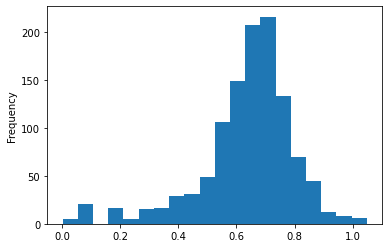

In [17]:
geocode['accuracy'].plot(kind='hist', bins=20)

In [18]:
geocode['accuracy'].describe()

count    1141.000000
mean        0.636900
std         0.163639
min         0.001000
25%         0.573914
50%         0.661501
75%         0.732723
max         1.049289
Name: accuracy, dtype: float64

There are some unsalvageable city names, but even with low accuracy score, most of the city or region belongs to their rightful country.

In [19]:
geocode.loc[geocode['accuracy']<0.2,:].sort_values('accuracy')

,geocodeid,citycleansed,ISO2,city,lat,lon,accuracy,confidence
1032,1032,university of copenhagen,DK,København,55.680150,12.572327,0.001,10.0
953,953,moscou tomsk,RU,Королёв,55.937621,37.857849,0.001,10.0
392,392,departement de la meuse,EG,None,31.207877,29.929238,0.001,10.0
406,406,tafileh,ZA,Emalahleni Local Municipality,-31.467666,27.159602,0.001,10.0
899,899,viienne,IN,Mysuru,12.288976,76.631501,0.001,10.0
1132,1132,frakfurt,BR,Contagem,-19.920076,-44.071621,0.100,8.0
104,104,sitias,GR,None,37.987666,23.664451,0.100,10.0
232,232,palaikastro sitia,GR,None,35.203901,26.110599,0.100,10.0
418,418,llle,CA,Clerval,48.688739,-79.451574,0.100,6.0
498,498,johanesburg,IL,אשקלון,31.677821,34.568610,0.100,8.0


### Create Travel Cycle

This is the most important part of the work. **Mission** is a generic concept that may cover **multiple travels**. Failing to capture this might imply a huge underestimation of travelled distances.

> We have no metadata about travels, we just know that **mission can have multiple travels** and we **assume traveller must come back to its origin** at the end of the mission.

Based on that hypothesis we build travel cycles to have as many travels as required to complete the mission cycle. Then we could assess distance associated to each travel and sum them up to get the complete travelled distance.

In [20]:
travels = df.groupby("mission_id").agg({'from_city': 'first', 'dest_city': list}, default='first')
travels = travels.reset_index().rename(columns={'from_city': 'from', 'dest_city': 'to'}).dropna()
travels.head(5)

,mission_id,from,to
0,0,bruxelles,"[londres, oxford]"
1,1,bruxelles,[londres]
2,2,bruxelles,[londres]
3,3,bruxelles,[londres]
4,4,bruxelles,[paris]


We create each edge of the cycle:

In [21]:
travels['chain'] = travels.apply(lambda x: [x['from']] + x['to'] + [x['from']], axis=1)
travels = travels.explode('chain')
travels['end'] = travels.groupby("mission_id")["chain"].shift(-1)
travels = travels.dropna(subset=['end']).reset_index(drop=True).reset_index().rename(columns={'index': 'travel_id'})
travels = travels.drop(['from', 'to'], axis=1).rename(columns={'chain': 'from', 'end': 'to'})

Eg.: Mission (`mission_id=0`) contains 3 travels:

 - from Brussels to London;
 - from London to Oxford;
 - from Oxford to Brussels.
 
It decomposes as follow:

In [22]:
travels.head(10)

,travel_id,mission_id,from,to
0,0,0,bruxelles,londres
1,1,0,londres,oxford
2,2,0,oxford,bruxelles
3,3,1,bruxelles,londres
4,4,1,londres,bruxelles
5,5,2,bruxelles,londres
6,6,2,londres,bruxelles
7,7,3,bruxelles,londres
8,8,3,londres,bruxelles
9,9,4,bruxelles,paris


Join destinations with geocoded cities:

In [23]:
travels = travels.merge(geocode.add_prefix('from_'), left_on='from', right_on='from_citycleansed', how='left')
travels = travels.merge(geocode.add_prefix('to_'), left_on='to', right_on='to_citycleansed', how='left')

In [24]:
travels = travels.drop(['from', 'to'], axis=1)

In [25]:
travels[['travel_id', 'mission_id', 'from_city', 'from_lon','from_lat', 'to_city', 'to_lon','to_lat']].head()

,travel_id,mission_id,from_city,from_lon,from_lat,to_city,to_lon,to_lat
0,0,0,Ville de Bruxelles - Stad Brussel,4.367437,50.843671,London,-0.127647,51.507322
1,1,0,London,-0.127647,51.507322,Oxford,-1.257850,51.752013
2,2,0,Oxford,-1.257850,51.752013,Ville de Bruxelles - Stad Brussel,4.367437,50.843671
3,3,1,Ville de Bruxelles - Stad Brussel,4.367437,50.843671,London,-0.127647,51.507322
4,4,1,London,-0.127647,51.507322,Ville de Bruxelles - Stad Brussel,4.367437,50.843671


### Clean Missions

Now we refactor a bit the datamodel of original mission dataset:

In [26]:
missions = missions.rename(columns={
    'debut': 'start', 'fin': 'stop', 'mode_deplacement': 'travel_type',
    'acronyme': 'acronym', 'faculte': 'faculty'
}).drop(['pays_origine', 'ville_origine', 'pays', 'lieu', 'ville', 'from_city', 'dest_city'], axis=1)
missions['travel_type'] = missions['travel_type'].replace({
    'avion_courte_distance': 'plane/short',
    'avion_long_courrier_eco': 'plane/eco',
    'avion_long_courrier_business': 'plane/first',
    'voiture_essence': 'car/gas',
    'voiture_diesel': 'car/diesel',
})
missions.sample(10)

,mission_id,start,stop,travel_type,acronym,faculty,elapsed
1303,1303,2014-03-31,2014-04-03,NaN,L&L,LTC,4
2123,2123,2016-05-07,2016-05-28,NaN,TI,LTC,22
4046,4046,2018-05-21,2018-05-25,train,L&L,LTC,5
444,444,2011-11-03,2011-11-03,NaN,SIC,LTC,1
5041,5041,2019-04-15,2019-04-17,train,L&L,LTC,3
3720,3720,2018-03-11,2018-03-16,plane/eco,L&L,LTC,6
1433,1433,2014-08-21,2014-08-23,NaN,L&L,LTC,3
3541,3541,2017-12-08,2017-12-08,NaN,DECA,LTC,1
3140,3140,2017-06-08,2017-06-12,NaN,SIC,LTC,5
577,577,2012-04-17,2012-04-17,NaN,SIC,LTC,1


And we join it with travel dataset:

In [27]:
travels = travels.merge(missions)

Complete travel dataset looks like:

In [28]:
travels

,travel_id,mission_id,from_geocodeid,from_citycleansed,from_ISO2,from_city,from_lat,from_lon,from_accuracy,from_confidence,...,to_lat,to_lon,to_accuracy,to_confidence,start,stop,travel_type,acronym,faculty,elapsed
0,0,0,0,bruxelles,BE,Ville de Bruxelles - Stad Brussel,50.843671,4.367437,0.777530,4.0,...,51.507322,-0.127647,0.830783,1.0,2010-05-28,2010-06-01,NaN,DECA,LTC,5
1,1,0,5,londres,GB,London,51.507322,-0.127647,0.830783,1.0,...,51.752013,-1.257850,0.760604,4.0,2010-05-28,2010-06-01,NaN,DECA,LTC,5
2,2,0,99,oxford,GB,Oxford,51.752013,-1.257850,0.760604,4.0,...,50.843671,4.367437,0.777530,4.0,2010-05-28,2010-06-01,NaN,DECA,LTC,5
3,3,1,0,bruxelles,BE,Ville de Bruxelles - Stad Brussel,50.843671,4.367437,0.777530,4.0,...,51.507322,-0.127647,0.830783,1.0,2010-06-22,2010-07-08,NaN,SIC,LTC,17
4,4,1,5,londres,GB,London,51.507322,-0.127647,0.830783,1.0,...,50.843671,4.367437,0.777530,4.0,2010-06-22,2010-07-08,NaN,SIC,LTC,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12802,12802,6128,36,amsterdam,NL,Amsterdam,52.372760,4.893604,0.826813,1.0,...,48.856697,2.351462,0.931710,2.0,2020-03-02,2020-03-03,train,DECS,SBS,2
12803,12803,6128,2,paris,FR,Paris,48.856697,2.351462,0.931710,2.0,...,52.372760,4.893604,0.826813,1.0,2020-03-02,2020-03-03,train,DECS,SBS,2
12804,12804,6129,0,bruxelles,BE,Ville de Bruxelles - Stad Brussel,50.843671,4.367437,0.777530,4.0,...,38.894893,-77.036553,0.849289,1.0,2020-01-28,2020-02-06,plane/eco,L&L,LTC,10
12805,12805,6129,267,washington,US,Washington,38.894893,-77.036553,0.849289,1.0,...,35.913154,-79.055780,0.746859,4.0,2020-01-28,2020-02-06,plane/eco,L&L,LTC,10


### Geodesic distance

At this point we can estimate distance for each travel, this step is critical and is subject to numerous inaccuracy sources:

 - **The real travel is unknown**:  we approximate it as the crow flies using Geodesic distance with respect to `WGS-84` ellipsoid;
 - **The tortuosity** (crookness) of the travel may **vary with travel types and distance**, at this point we roughly estimate it as a constant factor for each travel type but it should be modelled (reference requested);
 - **Plane flies at 10 km above the sea level**, which changes the radius we must use in Geodesic distance, but it also **depends on the travelled distance**;
 - With the current datamodel, it is **impossible to address mixed travel types** for a mission, which will impact the analysis;
 - There are **misattributed travel types** and a **lot of travel types are unknown**;
 - There are antipodal travels that may disturb the Geodesic distance convergence (Vincity);

Caution:

 > Do not use cartesian distance when dealing with long distance on a sphere, it will lead to meaningless quantities.



In [29]:
def distance(x):
    try:
        return geodesic((x['from_lat'], x['from_lon']),
                        (x['to_lat'], x['to_lon']),
                        ellipsoid='WGS-84').kilometers
    except:
        pass

In [30]:
travels['distance'] = travels.apply(distance, axis=1)

In [31]:
k = ['travel_id', 'mission_id', 'from_city', 'from_ISO2', 'to_city', 'to_ISO2', 'distance', 'elapsed']
travels[k].sample(10)

,travel_id,mission_id,from_city,from_ISO2,to_city,to_ISO2,distance,elapsed
12524,12524,5997,Ville de Bruxelles - Stad Brussel,BE,Genève,CH,532.607195,2
12234,12234,5857,London,GB,Ville de Bruxelles - Stad Brussel,BE,322.849447,1
4854,4854,2301,Leeds,GB,Ville de Bruxelles - Stad Brussel,BE,519.788917,4
6666,6666,3164,Porto,PT,Roma,IT,1758.735490,7
5164,5164,2450,Veurne,BE,Ville de Bruxelles - Stad Brussel,BE,122.486064,1
9157,9157,4362,None,IN,Ville de Bruxelles - Stad Brussel,BE,6423.401449,9
6390,6390,3032,Ville de Bruxelles - Stad Brussel,BE,Barcelona,ES,1065.007667,1
2954,2954,1400,Bari,IT,Ville de Bruxelles - Stad Brussel,BE,1446.582377,8
1996,1996,949,Bliesbruck,FR,Ville de Bruxelles - Stad Brussel,BE,278.633740,2
10524,10524,5023,Ville de Bruxelles - Stad Brussel,BE,Paris,FR,264.293514,1


In [32]:
travels.to_excel('data/travels.xlsx', index=False)

## Conclusions

We have valorized Missions Dataset prior to the Carbon Assessment of Business Travels. We showed that we can extract some useful metrics even if they are inaccurate and sampling is biased.

In order to perform a relevant analysis some keypoints must be addressed.

To perform a trial assessment based on current dataset:

 - [ ] Classify travel types for each travel;
 - [ ] Model tortuosity for each travel type in function of distance;
 
To perform a complete and robust assessment based on reliable dataset:

 - [ ] Improve underlying datamodel to collect required and constrained data at the source.
 - [ ] There is a prevalent sampling biais on Mission dataset due to its optional nature, we must inforce data collection at the institution level;

 
Even if not accurate and biaised, we do believe we could produce a crude estimation of the Carbon Assessment which will highlight needs and requirements to rigorously complete this task and produce a methodology to achieve it.